# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [28]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [29]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [30]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [31]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


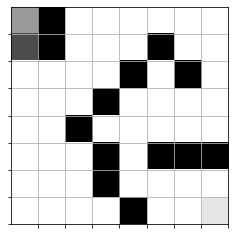

In [32]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [33]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [34]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [35]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [36]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    current_epoch = 0
    
         # For each epoch:
    for epoch in range(n_epoch):
        current_epoch += 1
        print('\n\n\n')
        print('-------------------------------')
        print('Epoch', current_epoch)
        print('-------------------------------')
        print('\n')
        #  Agent_cell = randomly select a free cell
        agent_cell = np.random.randint(0, high=7, size=2)
        # Reset the maze with agent set to above position
        qmaze.reset([0,0])
        #enviroment current state
        envstate = qmaze.observe()
        loss = 0
        n_episodes = 0
        
        
        # While game is not over
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
            
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))

            # Take the action
            envstate, reward, game_status = qmaze.act(action)
            # Increase episode count because taking an action makes an episode
            n_episodes += 1
            # Store episode in Experience replay object
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)                

            #evaluate loss
            inputs,targets = experience.get_data()            
            history = model.fit(inputs, targets, epochs=8, batch_size=24, verbose=0)
            loss = model.evaluate(inputs, targets)

            # if pirate agent won game
            if episode [4] == 'win':
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                break
            # if pirate agent lost the game
            elif episode[4] == 'lose':
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                break
            # else the game is not over

        #    If the win rate is above the threshold
        if win_rate > epsilon:
            print('\n')
            print('Win rate is larger than epsilon')
            if completion_check(model, qmaze) == True:
                print('completion_check() passes')


    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break


    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

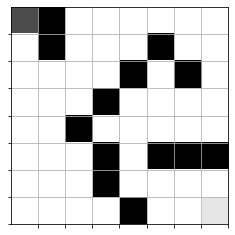

In [37]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [38]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)





-------------------------------
Epoch 1
-------------------------------


10/10 [==============================] - 0s 2ms/step
Epoch: 000/14999 | Loss: 0.0003 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 10.8 seconds




-------------------------------
Epoch 2
-------------------------------


10/10 [==============================] - 0s 138us/step


10/10 [==============================] - 0s 0us/step
Epoch: 001/14999 | Loss: 0.0003 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 19.3 seconds




-------------------------------
Epoch 3
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 199us/step
Epoch: 002/14999 | Loss: 0.0003 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 27.5 seconds




-------------------------------
Epoch 4
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step
Epoch: 003/14999 | Loss: 0.0002 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 36.2 seconds




-------------------------------
Epoch 5
-------------------------------


10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
Epoch: 004/14999 | Loss: 0.0003 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 45.9 seconds




-------------------------------
Epoch 6
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 005/14999 | Loss: 0.0002 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 54.9 seconds




-------------------------------
Epoch 7
-------------------------------


10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 107us/step
Epoch: 006/14999 | Loss: 0.0010 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 63.9 seconds




-------------------------------
Epoch 8
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 007/14999 | Loss: 0.0005 | Episodes: 160 | Win count: 0 | Win rate: 0.000 | time: 74.0 seconds




-------------------------------
Epoch 9
-------------------------------


10/10 [==============================] - 0s 2ms/step


10/10 [==============================] - 0s 0us/step
Epoch: 008/14999 | Loss: 0.0013 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 87.4 seconds




-------------------------------
Epoch 10
-------------------------------


10/10 [==============================] - 0s 109us/step


10/10 [==============================] - 0s 2ms/step
Epoch: 009/14999 | Loss: 0.0020 | Episodes: 159 | Win count: 0 | Win rate: 0.000 | time: 102.8 seconds




-------------------------------
Epoch 11
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 010/14999 | Loss: 0.0009 | Episodes: 129 | Win count: 1 | Win rate: 0.091 | time: 116.4 seconds




-------------------------------
Epoch 12
-------------------------------


10/10 [==============================] - 0s 27us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 011/14999 | Loss: 0.0017 | Episodes: 98 | Win count: 2 | Win rate: 0.167 | time: 127.2 seconds




-------------------------------
Epoch 13
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 012/14999 | Loss: 0.0008 | Episodes: 149 | Win count: 3 | Win rate: 0.231 | time: 143.2 seconds




-------------------------------
Epoch 14
-------------------------------


10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 199us/step


Win rate is larger than epsilon
Epoch: 013/14999 | Loss: 0.0034 | Episodes: 144 | Win count: 3 | Win rate: 0.214 | time: 158.0 seconds




-------------------------------
Epoch 15
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 014/14999 | Loss: 0.0015 | Episodes: 56 | Win count: 4 | Win rate: 0.267 | time: 164.8 seconds




-------------------------------
Epoch 16
-------------------------------


10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 015/14999 | Loss: 0.0004 | Episodes: 77 | Win count: 5 | Win rate: 0.312 | time: 172.5 seconds




-------------------------------
Epoch 17
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 016/14999 | Loss: 0.0012 | Episodes: 51 | Win count: 6 | Win rate: 0.353 | time: 177.6 seconds




-------------------------------
Epoch 18
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 017/14999 | Loss: 0.0009 | Episodes: 75 | Win count: 7 | Win rate: 0.389 | time: 185.8 seconds




-------------------------------
Epoch 19
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 018/14999 | Loss: 0.0005 | Episodes: 36 | Win count: 8 | Win rate: 0.421 | time: 189.9 seconds




-------------------------------
Epoch 20
-------------------------------


10/10 [==============================] - 0s 300us/step


Win rate is larger than epsilon
Epoch: 019/14999 | Loss: 0.0010 | Episodes: 64 | Win count: 9 | Win rate: 0.450 | time: 195.2 seconds




-------------------------------
Epoch 21
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 020/14999 | Loss: 0.0004 | Episodes: 70 | Win count: 10 | Win rate: 0.476 | time: 201.8 seconds




-------------------------------
Epoch 22
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 021/14999 | Loss: 0.0020 | Episodes: 73 | Win count: 11 | Win rate: 0.500 | time: 208.6 seconds




-------------------------------
Epoch 23
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 022/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 12 | Win rate: 0.522 | time: 211.8 seconds




-------------------------------
Epoch 24
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 023/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 13 | Win rate: 0.542 | time: 215.1 seconds




-------------------------------
Epoch 25
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 024/14999 | Loss: 0.0014 | Episodes: 38 | Win count: 14 | Win rate: 0.560 | time: 218.7 seconds




-------------------------------
Epoch 26
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 025/14999 | Loss: 0.0009 | Episodes: 104 | Win count: 15 | Win rate: 0.577 | time: 229.5 seconds




-------------------------------
Epoch 27
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 026/14999 | Loss: 0.0010 | Episodes: 40 | Win count: 16 | Win rate: 0.593 | time: 233.9 seconds




-------------------------------
Epoch 28
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 027/14999 | Loss: 0.0008 | Episodes: 54 | Win count: 17 | Win rate: 0.607 | time: 240.8 seconds




-------------------------------
Epoch 29
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 028/14999 | Loss: 0.0011 | Episodes: 76 | Win count: 18 | Win rate: 0.621 | time: 249.0 seconds




-------------------------------
Epoch 30
-------------------------------


10/10 [==============================] - 0s 104us/step


Win rate is larger than epsilon
Epoch: 029/14999 | Loss: 0.0013 | Episodes: 62 | Win count: 19 | Win rate: 0.633 | time: 256.3 seconds




-------------------------------
Epoch 31
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 030/14999 | Loss: 0.0006 | Episodes: 141 | Win count: 19 | Win rate: 0.613 | time: 269.7 seconds




-------------------------------
Epoch 32
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 031/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 20 | Win rate: 0.625 | time: 272.4 seconds




-------------------------------
Epoch 33
-------------------------------


10/10 [==============================] - 0s 2ms/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 032/14999 | Loss: 0.0005 | Episodes: 159 | Win count: 21 | Win rate: 0.636 | time: 287.0 seconds




-------------------------------
Epoch 34
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 033/14999 | Loss: 0.0015 | Episodes: 50 | Win count: 22 | Win rate: 0.647 | time: 291.2 seconds




-------------------------------
Epoch 35
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 034/14999 | Loss: 0.0009 | Episodes: 97 | Win count: 23 | Win rate: 0.657 | time: 300.6 seconds




-------------------------------
Epoch 36
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 035/14999 | Loss: 0.0013 | Episodes: 53 | Win count: 24 | Win rate: 0.667 | time: 305.1 seconds




-------------------------------
Epoch 37
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 036/14999 | Loss: 0.0005 | Episodes: 44 | Win count: 25 | Win rate: 0.676 | time: 308.7 seconds




-------------------------------
Epoch 38
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 037/14999 | Loss: 0.0004 | Episodes: 44 | Win count: 26 | Win rate: 0.684 | time: 312.6 seconds




-------------------------------
Epoch 39
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 038/14999 | Loss: 0.0010 | Episodes: 41 | Win count: 27 | Win rate: 0.692 | time: 316.1 seconds




-------------------------------
Epoch 40
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 039/14999 | Loss: 0.0013 | Episodes: 39 | Win count: 28 | Win rate: 0.700 | time: 319.5 seconds




-------------------------------
Epoch 41
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 040/14999 | Loss: 0.0010 | Episodes: 42 | Win count: 29 | Win rate: 0.707 | time: 323.6 seconds





10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 041/14999 | Loss: 0.0003 | Episodes: 67 | Win count: 30 | Win rate: 0.714 | time: 329.2 seconds




-------------------------------
Epoch 43
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 105us/step


Win rate is larger than epsilon
Epoch: 042/14999 | Loss: 0.0030 | Episodes: 95 | Win count: 31 | Win rate: 0.721 | time: 336.2 seconds




-------------------------------
Epoch 44
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 043/14999 | Loss: 0.0015 | Episodes: 34 | Win count: 32 | Win rate: 0.727 | time: 338.9 seconds




-------------------------------
Epoch 45
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 044/14999 | Loss: 0.0013 | Episodes: 144 | Win count: 33 | Win rate: 0.733 | time: 350.6 seconds




-------------------------------
Epoch 46
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 045/14999 | Loss: 0.0008 | Episodes: 100 | Win count: 34 | Win rate: 0.739 | time: 359.9 seconds




-------------------------------
Epoch 47
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 046/14999 | Loss: 0.0008 | Episodes: 78 | Win count: 35 | Win rate: 0.745 | time: 366.5 seconds




-------------------------------
Epoch 48
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 047/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 36 | Win rate: 0.750 | time: 369.4 seconds




-------------------------------
Epoch 49
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 048/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 37 | Win rate: 0.755 | time: 373.0 seconds




-------------------------------
Epoch 50
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 049/14999 | Loss: 0.0007 | Episodes: 59 | Win count: 38 | Win rate: 0.760 | time: 379.3 seconds




-------------------------------
Epoch 51
-------------------------------


10/10 [==============================] - 0s 424us/step


Win rate is larger than epsilon
Epoch: 050/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 39 | Win rate: 0.765 | time: 382.5 seconds




-------------------------------
Epoch 52
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 051/14999 | Loss: 0.0014 | Episodes: 73 | Win count: 40 | Win rate: 0.769 | time: 388.3 seconds




-------------------------------
Epoch 53
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 052/14999 | Loss: 0.0015 | Episodes: 49 | Win count: 41 | Win rate: 0.774 | time: 392.8 seconds




-------------------------------
Epoch 54
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 053/14999 | Loss: 0.0010 | Episodes: 53 | Win count: 42 | Win rate: 0.778 | time: 399.5 seconds




-------------------------------
Epoch 55
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 213us/step


Win rate is larger than epsilon
Epoch: 054/14999 | Loss: 0.0014 | Episodes: 30 | Win count: 43 | Win rate: 0.782 | time: 6.71 minutes




-------------------------------
Epoch 56
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 055/14999 | Loss: 0.0020 | Episodes: 50 | Win count: 44 | Win rate: 0.786 | time: 6.79 minutes




-------------------------------
Epoch 57
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 056/14999 | Loss: 0.0011 | Episodes: 61 | Win count: 45 | Win rate: 0.789 | time: 6.88 minutes




-------------------------------
Epoch 58
-------------------------------


10/10 [==============================] - 0s 201us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 057/14999 | Loss: 0.0011 | Episodes: 49 | Win count: 46 | Win rate: 0.793 | time: 6.96 minutes




-------------------------------
Epoch 59
-------------------------------


10/10 [==============================] - 0s 637us/step


Win rate is larger than epsilon
Epoch: 058/14999 | Loss: 0.0015 | Episodes: 40 | Win count: 47 | Win rate: 0.797 | time: 7.04 minutes




-------------------------------
Epoch 60
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 059/14999 | Loss: 0.0007 | Episodes: 64 | Win count: 48 | Win rate: 0.800 | time: 7.12 minutes




-------------------------------
Epoch 61
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 174us/step


Win rate is larger than epsilon
Epoch: 060/14999 | Loss: 0.0011 | Episodes: 38 | Win count: 49 | Win rate: 0.803 | time: 7.18 minutes




-------------------------------
Epoch 62
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 061/14999 | Loss: 0.0005 | Episodes: 75 | Win count: 50 | Win rate: 0.806 | time: 7.29 minutes




-------------------------------
Epoch 63
-------------------------------


10/10 [==============================] - 0s 2ms/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 062/14999 | Loss: 0.0007 | Episodes: 48 | Win count: 51 | Win rate: 0.810 | time: 7.37 minutes




-------------------------------
Epoch 64
-------------------------------


10/10 [==============================] - 0s 97us/step


Win rate is larger than epsilon
Epoch: 063/14999 | Loss: 0.0287 | Episodes: 42 | Win count: 52 | Win rate: 0.812 | time: 7.44 minutes




-------------------------------
Epoch 65
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 064/14999 | Loss: 0.0005 | Episodes: 60 | Win count: 53 | Win rate: 0.815 | time: 7.54 minutes




-------------------------------
Epoch 66
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 065/14999 | Loss: 0.0012 | Episodes: 47 | Win count: 54 | Win rate: 0.818 | time: 7.64 minutes




-------------------------------
Epoch 67
-------------------------------


10/10 [==============================] - 0s 340us/step


Win rate is larger than epsilon
Epoch: 066/14999 | Loss: 0.0005 | Episodes: 72 | Win count: 55 | Win rate: 0.821 | time: 7.79 minutes




-------------------------------
Epoch 68
-------------------------------


10/10 [==============================] - 0s 620us/step


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 067/14999 | Loss: 0.0023 | Episodes: 78 | Win count: 56 | Win rate: 0.824 | time: 7.93 minutes




-------------------------------
Epoch 69
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 068/14999 | Loss: 0.0009 | Episodes: 61 | Win count: 57 | Win rate: 0.826 | time: 8.05 minutes




-------------------------------
Epoch 70
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 069/14999 | Loss: 0.0014 | Episodes: 70 | Win count: 58 | Win rate: 0.829 | time: 8.19 minutes




-------------------------------
Epoch 71
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 070/14999 | Loss: 0.0007 | Episodes: 67 | Win count: 59 | Win rate: 0.831 | time: 8.29 minutes




-------------------------------
Epoch 72
-------------------------------


10/10 [==============================] - 0s 198us/step


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 071/14999 | Loss: 0.0018 | Episodes: 78 | Win count: 60 | Win rate: 0.833 | time: 8.41 minutes




-------------------------------
Epoch 73
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 072/14999 | Loss: 0.0013 | Episodes: 46 | Win count: 61 | Win rate: 0.836 | time: 8.48 minutes




-------------------------------
Epoch 74
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 073/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 62 | Win rate: 0.838 | time: 8.54 minutes




-------------------------------
Epoch 75
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 074/14999 | Loss: 0.0021 | Episodes: 32 | Win count: 63 | Win rate: 0.840 | time: 8.60 minutes




---

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 075/14999 | Loss: 0.0012 | Episodes: 30 | Win count: 64 | Win rate: 0.842 | time: 8.64 minutes




-------------------------------
Epoch 77
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 076/14999 | Loss: 0.0007 | Episodes: 42 | Win count: 65 | Win rate: 0.844 | time: 8.70 minutes




-------------------------------
Epoch 78
-------------------------------


10/10 [==============================] - 0s 196us/step


Win rate is larger than epsilon
Epoch: 077/14999 | Loss: 0.0014 | Episodes: 30 | Win count: 66 | Win rate: 0.846 | time: 8.75 minutes




-------------------------------
Epoch 79
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 078/14999 | Loss: 0.0012 | Episodes: 34 | Win count: 67 | Win rate: 0.848 | time: 8.79 minutes




-

10/10 [==============================] - 0s 159us/step


Win rate is larger than epsilon
Epoch: 079/14999 | Loss: 0.0006 | Episodes: 45 | Win count: 68 | Win rate: 0.850 | time: 8.86 minutes




-------------------------------
Epoch 81
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 080/14999 | Loss: 0.0015 | Episodes: 29 | Win count: 69 | Win rate: 0.852 | time: 8.91 minutes




-------------------------------
Epoch 82
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 081/14999 | Loss: 0.0017 | Episodes: 28 | Win count: 70 | Win rate: 0.854 | time: 8.97 minutes




-------------------------------
Epoch 83
-------------------------------


10/10 [==============================] - 0s 354us/step


Win rate is larger than epsilon
Epoch: 082/14999 | Loss: 0.0008 | Episodes: 39 | Win count: 71 | Win rate: 0.855 | time: 9.04 minutes





10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 083/14999 | Loss: 0.0013 | Episodes: 38 | Win count: 72 | Win rate: 0.857 | time: 9.10 minutes




-------------------------------
Epoch 85
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 084/14999 | Loss: 0.0022 | Episodes: 48 | Win count: 73 | Win rate: 0.859 | time: 9.18 minutes




-------------------------------
Epoch 86
-------------------------------


10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 085/14999 | Loss: 0.0014 | Episodes: 30 | Win count: 74 | Win rate: 0.860 | time: 9.25 minutes




-------------------------------
Epoch 87
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 086/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 75 | Win rate: 0.862 | time: 9.30 minutes




-

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 087/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 76 | Win rate: 0.864 | time: 9.36 minutes




-------------------------------
Epoch 89
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 088/14999 | Loss: 0.0008 | Episodes: 42 | Win count: 77 | Win rate: 0.865 | time: 9.43 minutes




-------------------------------
Epoch 90
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 089/14999 | Loss: 0.0009 | Episodes: 56 | Win count: 78 | Win rate: 0.867 | time: 9.52 minutes




-------------------------------
Epoch 91
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 090/14999 | Loss: 0.0003 | Episodes: 58 | Win count: 79 | Win rate: 0.868 | time: 9.61 minutes




-------------------------------
Epoch 92
-------------------------------


10/10 [==============================] - 0s 97us/step


Win rate is larger than epsilon
Epoch: 091/14999 | Loss: 0.0003 | Episodes: 42 | Win count: 80 | Win rate: 0.870 | time: 9.68 minutes




-------------------------------
Epoch 93
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 092/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 81 | Win rate: 0.871 | time: 9.75 minutes




-------------------------------
Epoch 94
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 093/14999 | Loss: 0.0024 | Episodes: 32 | Win count: 82 | Win rate: 0.872 | time: 9.81 minutes




--

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 094/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 83 | Win rate: 0.874 | time: 9.88 minutes




-------------------------------
Epoch 96
-------------------------------


10/10 [==============================] - 0s 115us/step


Win rate is larger than epsilon
Epoch: 095/14999 | Loss: 0.0009 | Episodes: 42 | Win count: 84 | Win rate: 0.875 | time: 9.95 minutes




-------------------------------
Epoch 97
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 096/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 85 | Win rate: 0.876 | time: 10.00 minutes




-------------------------------
Epoch 98
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 097/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 86 | Win rate: 0.878 | time: 10.06 minutes



10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 098/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 87 | Win rate: 0.879 | time: 10.13 minutes




-------------------------------
Epoch 100
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 099/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 88 | Win rate: 0.880 | time: 10.18 minutes




-------------------------------
Epoch 101
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 100/14999 | Loss: 0.0013 | Episodes: 34 | Win count: 89 | Win rate: 0.881 | time: 10.25 minutes




-------------------------------
Epoch 102
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 101/14999 | Loss: 0.0004 | Episodes: 38 | Win count: 90 | Win rate: 0.882 | time: 10.30 minutes


10/10 [==============================] - 0s 80us/step


Win rate is larger than epsilon
Epoch: 102/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 91 | Win rate: 0.883 | time: 10.35 minutes




-------------------------------
Epoch 104
-------------------------------


10/10 [==============================] - 0s 91us/step


Win rate is larger than epsilon
Epoch: 103/14999 | Loss: 0.0016 | Episodes: 46 | Win count: 92 | Win rate: 0.885 | time: 10.42 minutes




-------------------------------
Epoch 105
-------------------------------


10/10 [==============================] - 0s 183us/step


Win rate is larger than epsilon
Epoch: 104/14999 | Loss: 0.0018 | Episodes: 48 | Win count: 93 | Win rate: 0.886 | time: 10.49 minutes




-------------------------------
Epoch 106
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 105/14999 | Loss: 0.0015 | Episodes: 39 | Win count: 94 | Win rate: 0.887 | time: 10.56 minutes




-------------------------------
Epoch 107
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 106/14999 | Loss: 0.0009 | Episodes: 40 | Win count: 95 | Win rate: 0.888 | time: 10.62 minutes




-------------------------------
Epoch 108
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 107/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 96 | Win rate: 0.889 | time: 10.67 minutes




-------------------------------
Epoch 109
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 108/14999 | Loss: 0.0001 | Episodes: 61 | Win count: 97 | Win rate: 0.890 | time: 10.75 minutes






-------------------------------
Epoch 110
-------------------------------


10/10 [==============================] - 0s 184us/step


Win rate is larger than epsilon
Epoch: 109/14999 | Loss: 0.0006 | Episodes: 46 | Win count: 98 | Win rate: 0.891 | time: 10.82 minutes




-------------------------------
Epoch 111
-------------------------------


10/10 [==============================] - 0s 105us/step


Win rate is larger than epsilon
Epoch: 110/14999 | Loss: 0.0012 | Episodes: 36 | Win count: 99 | Win rate: 0.892 | time: 10.89 minutes




-------------------------------
Epoch 112
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 111/14999 | Loss: 0.0018 | Episodes: 46 | Win count: 100 | Win rate: 0.893 | time: 10.95 minutes




-------------------------------
Epoch 113
-------------------------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 274us/step


Win rate is larger than epsilon
Epoch: 112/14999 | Loss: 0.0002 | Episodes: 33 | Win count: 101 | Win rate: 0.894 | time: 10.99 minutes




-------------------------------
Epoch 114
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 113/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 102 | Win rate: 0.895 | time: 11.06 minutes




-------------------------------
Epoch 115
-------------------------------


10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 114/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 103 | Win rate: 0.896 | time: 11.12 minutes




-------------------------------
Epoch 116
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 115/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 104 | Win rate: 0.897 | time: 11.17 

10/10 [==============================] - 0s 209us/step


Win rate is larger than epsilon
Epoch: 116/14999 | Loss: 0.0006 | Episodes: 53 | Win count: 105 | Win rate: 0.897 | time: 11.24 minutes




-------------------------------
Epoch 118
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 117/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 106 | Win rate: 0.898 | time: 11.28 minutes




-------------------------------
Epoch 119
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 118/14999 | Loss: 0.0010 | Episodes: 44 | Win count: 107 | Win rate: 0.899 | time: 11.34 minutes




-------------------------------
Epoch 120
-------------------------------


10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 119/14999 | Loss: 0.0010 | Episodes: 61 | Win count: 108 | Win rate: 0.900 | time: 11.42 minutes




-------------------------------
Epoch 121
-------------------------------


10/10 [==============================] - 0s 197us/step


Win rate is larger than epsilon
Epoch: 120/14999 | Loss: 0.0011 | Episodes: 36 | Win count: 109 | Win rate: 0.901 | time: 11.47 minutes




-------------------------------
Epoch 122
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 121/14999 | Loss: 0.0012 | Episodes: 32 | Win count: 110 | Win rate: 0.902 | time: 11.52 minutes




-------------------------------
Epoch 123
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 122/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 111 | Win rate: 0.902 | time: 11.57 mi

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 123/14999 | Loss: 0.0004 | Episodes: 42 | Win count: 112 | Win rate: 0.903 | time: 11.64 minutes




-------------------------------
Epoch 125
-------------------------------


10/10 [==============================] - 0s 165us/step


Win rate is larger than epsilon
Epoch: 124/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 113 | Win rate: 0.904 | time: 11.71 minutes




-------------------------------
Epoch 126
-------------------------------


10/10 [==============================] - 0s 98us/step


Win rate is larger than epsilon
Epoch: 125/14999 | Loss: 0.0002 | Episodes: 39 | Win count: 114 | Win rate: 0.905 | time: 11.78 minutes




-------------------------------
Epoch 127
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 126/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 115 | Win rate: 0.906 | time: 11.84

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 127/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 116 | Win rate: 0.906 | time: 11.90 minutes




-------------------------------
Epoch 129
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 128/14999 | Loss: 0.0002 | Episodes: 39 | Win count: 117 | Win rate: 0.907 | time: 11.99 minutes




-------------------------------
Epoch 130
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 129/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 118 | Win rate: 0.908 | time: 12.07 minutes




-------------------------------
Epoch 131
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 130/14999 | Loss: 0.0001 | Episodes: 48 | Win count: 119 | Win rate: 0.908 | time: 12.14 minu

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 131/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 120 | Win rate: 0.909 | time: 12.22 minutes




-------------------------------
Epoch 133
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 132/14999 | Loss: 0.0002 | Episodes: 46 | Win count: 121 | Win rate: 0.910 | time: 12.31 minutes




-------------------------------
Epoch 134
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 133/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 122 | Win rate: 0.910 | time: 12.36 minutes




-------------------------------
Epoch 135
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 134/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 123 | Win rate: 0.911 | time: 12.41 min

10/10 [==============================] - 0s 149us/step


Win rate is larger than epsilon
Epoch: 135/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 124 | Win rate: 0.912 | time: 12.48 minutes




-------------------------------
Epoch 137
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 136/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 125 | Win rate: 0.912 | time: 12.53 minutes




-------------------------------
Epoch 138
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 137/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 126 | Win rate: 0.913 | time: 12.58 minutes




-------------------------------
Epoch 139
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 138/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 127 | Win rate: 0.914 | time: 12.65 mi

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 140/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 129 | Win rate: 0.915 | time: 12.75 minutes




-------------------------------
Epoch 142
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 141/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 130 | Win rate: 0.915 | time: 12.81 minutes




-------------------------------
Epoch 143
-------------------------------


10/10 [==============================] - 0s 86us/step


Win rate is larger than epsilon
Epoch: 142/14999 | Loss: 0.0011 | Episodes: 35 | Win count: 131 | Win rate: 0.916 | time: 12.87 minutes




-------------------------------
Epoch 144
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 143/14999 | Loss: 0.0019 | Episodes: 38 | Win count: 132 | Win rate: 0.917 | time: 12.94 min

10/10 [==============================] - 0s 210us/step


Win rate is larger than epsilon
Epoch: 144/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 133 | Win rate: 0.917 | time: 13.01 minutes




-------------------------------
Epoch 146
-------------------------------


10/10 [==============================] - 0s 98us/step


Win rate is larger than epsilon
Epoch: 145/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 134 | Win rate: 0.918 | time: 13.06 minutes




-------------------------------
Epoch 147
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 146/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 135 | Win rate: 0.918 | time: 13.12 minutes




-------------------------------
Epoch 148
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 147/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 136 | Win rate: 0.919 | time: 13.17 m

10/10 [==============================] - 0s 97us/step


Win rate is larger than epsilon
Epoch: 148/14999 | Loss: 0.0001 | Episodes: 46 | Win count: 137 | Win rate: 0.919 | time: 13.23 minutes




-------------------------------
Epoch 150
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 149/14999 | Loss: 0.0005 | Episodes: 36 | Win count: 138 | Win rate: 0.920 | time: 13.29 minutes




-------------------------------
Epoch 151
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 150/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 139 | Win rate: 0.921 | time: 13.35 minutes




-------------------------------
Epoch 152
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 151/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 140 | Win rate: 0.921 | time: 13.42 m

10/10 [==============================] - 0s 71us/step


Win rate is larger than epsilon
Epoch: 152/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 141 | Win rate: 0.922 | time: 13.48 minutes




-------------------------------
Epoch 154
-------------------------------


10/10 [==============================] - 0s 403us/step


Win rate is larger than epsilon
Epoch: 153/14999 | Loss: 0.0008 | Episodes: 47 | Win count: 142 | Win rate: 0.922 | time: 13.55 minutes




-------------------------------
Epoch 155
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 154/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 143 | Win rate: 0.923 | time: 13.60 minutes




-------------------------------
Epoch 156
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 155/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 144 | Win rate: 0.923 | time: 13.65 m

10/10 [==============================] - 0s 340us/step


Win rate is larger than epsilon
Epoch: 157/14999 | Loss: 0.0009 | Episodes: 48 | Win count: 146 | Win rate: 0.924 | time: 13.77 minutes




-------------------------------
Epoch 159
-------------------------------


10/10 [==============================] - 0s 124us/step


Win rate is larger than epsilon
Epoch: 158/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 147 | Win rate: 0.925 | time: 13.81 minutes




-------------------------------
Epoch 160
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 159/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 148 | Win rate: 0.925 | time: 13.86 minutes




-------------------------------
Epoch 161
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 160/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 149 | Win rate: 0.925 | time: 13.9

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 161/14999 | Loss: 0.0007 | Episodes: 41 | Win count: 150 | Win rate: 0.926 | time: 13.98 minutes




-------------------------------
Epoch 163
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 162/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 151 | Win rate: 0.926 | time: 14.03 minutes




-------------------------------
Epoch 164
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 163/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 152 | Win rate: 0.927 | time: 14.09 minutes




-------------------------------
Epoch 165
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 164/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 153 | Win rate: 0.927 | time: 14.15 minu

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 165/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 154 | Win rate: 0.928 | time: 14.22 minutes




-------------------------------
Epoch 167
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 166/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 155 | Win rate: 0.928 | time: 14.29 minutes




-------------------------------
Epoch 168
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 167/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 156 | Win rate: 0.929 | time: 14.33 minutes




-------------------------------
Epoch 169
-------------------------------


10/10 [==============================] - 0s 194us/step


Win rate is larger than epsilon
Epoch: 168/14999 | Loss: 0.0013 | Episodes: 27 | Win count: 157 | Win rate: 0.929 | time: 14.37 

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 170/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 159 | Win rate: 0.930 | time: 14.47 minutes




-------------------------------
Epoch 172
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 171/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 160 | Win rate: 0.930 | time: 14.53 minutes




-------------------------------
Epoch 173
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 172/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 161 | Win rate: 0.931 | time: 14.60 minutes




-------------------------------
Epoch 174
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 173/14999 | Loss: 0.0002 | Episodes: 40 | Win count: 162 | Win rate: 0.931 | time: 14.67 minu

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 174/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 163 | Win rate: 0.931 | time: 14.72 minutes




-------------------------------
Epoch 176
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 175/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 164 | Win rate: 0.932 | time: 14.77 minutes




-------------------------------
Epoch 177
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 176/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 165 | Win rate: 0.932 | time: 14.81 minutes




-------------------------------
Epoch 178
-------------------------------


10/10 [==============================] - 0s 193us/step


Win rate is larger than epsilon
Epoch: 177/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 166 | Win rate: 0.933 | time: 14.85 mi

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 179/14999 | Loss: 0.0000 | Episodes: 63 | Win count: 168 | Win rate: 0.933 | time: 15.03 minutes




-------------------------------
Epoch 181
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 180/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 169 | Win rate: 0.934 | time: 15.09 minutes




-------------------------------
Epoch 182
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 181/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 170 | Win rate: 0.934 | time: 15.15 minutes




-------------------------------
Epoch 183
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 182/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 171 | Win rate: 0.934 | time: 15.21 minu

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 183/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 172 | Win rate: 0.935 | time: 15.27 minutes




-------------------------------
Epoch 185
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 184/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 173 | Win rate: 0.935 | time: 15.32 minutes




-------------------------------
Epoch 186
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 185/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 174 | Win rate: 0.935 | time: 15.36 minutes




-------------------------------
Epoch 187
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 186/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 175 | Win rate: 0.936 | time: 15.41 minu

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 189/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 178 | Win rate: 0.937 | time: 15.56 minutes




-------------------------------
Epoch 191
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 190/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 179 | Win rate: 0.937 | time: 15.61 minutes




-------------------------------
Epoch 192
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 191/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 180 | Win rate: 0.938 | time: 15.69 minutes




-------------------------------
Epoch 193
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 192/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 181 | Win rate: 0.938 | time: 15.75 minu





-------------------------------
Epoch 195
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 194/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 183 | Win rate: 0.938 | time: 15.89 minutes




-------------------------------
Epoch 196
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 195/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 184 | Win rate: 0.939 | time: 15.95 minutes




-------------------------------
Epoch 197
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 196/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 185 | Win rate: 0.939 | time: 16.00 minutes




-------------------------------
Epoch 198
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 197/14999 |

10/10 [==============================] - 0s 110us/step


Win rate is larger than epsilon
Epoch: 198/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 187 | Win rate: 0.940 | time: 16.11 minutes




-------------------------------
Epoch 200
-------------------------------


10/10 [==============================] - 0s 18us/step


Win rate is larger than epsilon
Epoch: 199/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 188 | Win rate: 0.940 | time: 16.15 minutes




-------------------------------
Epoch 201
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 200/14999 | Loss: 0.0004 | Episodes: 40 | Win count: 189 | Win rate: 0.940 | time: 16.21 minutes




-------------------------------
Epoch 202
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 201/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 190 | Win rate: 0.941 | time: 16.26 m

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 203/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 192 | Win rate: 0.941 | time: 16.38 minutes




-------------------------------
Epoch 205
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 204/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 193 | Win rate: 0.941 | time: 16.44 minutes




-------------------------------
Epoch 206
-------------------------------


10/10 [==============================] - 0s 122us/step


Win rate is larger than epsilon
Epoch: 205/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 194 | Win rate: 0.942 | time: 16.49 minutes




-------------------------------
Epoch 207
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 206/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 195 | Win rate: 0.942 | time: 16.55 





-------------------------------
Epoch 209
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 208/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 197 | Win rate: 0.943 | time: 16.65 minutes




-------------------------------
Epoch 210
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 209/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 198 | Win rate: 0.943 | time: 16.70 minutes




-------------------------------
Epoch 211
-------------------------------


10/10 [==============================] - 0s 199us/step


Win rate is larger than epsilon
Epoch: 210/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 199 | Win rate: 0.943 | time: 16.74 minutes




-------------------------------
Epoch 212
-------------------------------


10/10 [==============================] - 0s 285us/step


Win rate is larger than epsilon
Epoch: 211/14999

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 212/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 201 | Win rate: 0.944 | time: 16.83 minutes




-------------------------------
Epoch 214
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 213/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 202 | Win rate: 0.944 | time: 16.87 minutes




-------------------------------
Epoch 215
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 214/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 203 | Win rate: 0.944 | time: 16.92 minutes




-------------------------------
Epoch 216
-------------------------------


10/10 [==============================] - 0s 201us/step


Win rate is larger than epsilon
Epoch: 215/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 204 | Win rate: 0.944 | time: 16.98

10/10 [==============================] - 0s 97us/step


Win rate is larger than epsilon
Epoch: 217/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 206 | Win rate: 0.945 | time: 17.07 minutes




-------------------------------
Epoch 219
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 218/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 207 | Win rate: 0.945 | time: 17.12 minutes




-------------------------------
Epoch 220
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 219/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 208 | Win rate: 0.945 | time: 17.18 minutes




-------------------------------
Epoch 221
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 220/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 209 | Win rate: 0.946 | time: 17.23

Epoch: 221/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 210 | Win rate: 0.946 | time: 17.29 minutes




-------------------------------
Epoch 223
-------------------------------


10/10 [==============================] - 0s 108us/step


Win rate is larger than epsilon
Epoch: 222/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 211 | Win rate: 0.946 | time: 17.34 minutes




-------------------------------
Epoch 224
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 223/14999 | Loss: 0.0003 | Episodes: 55 | Win count: 212 | Win rate: 0.946 | time: 17.42 minutes




-------------------------------
Epoch 225
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 224/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 213 | Win rate: 0.947 | time: 17.47 minutes




-------------------------------
Epoch 226
-------------------------------


1

10/10 [==============================] - 0s 201us/step


Win rate is larger than epsilon
Epoch: 226/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 215 | Win rate: 0.947 | time: 17.56 minutes




-------------------------------
Epoch 228
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 227/14999 | Loss: 0.0000 | Episodes: 63 | Win count: 216 | Win rate: 0.947 | time: 17.66 minutes




-------------------------------
Epoch 229
-------------------------------


10/10 [==============================] - 0s 97us/step


Win rate is larger than epsilon
Epoch: 228/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 217 | Win rate: 0.948 | time: 17.72 minutes




-------------------------------
Epoch 230
-------------------------------


10/10 [==============================] - 0s 110us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 229/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 218 | Win rate: 0.948 | time: 17.77 minutes




-------------------------------
Epoch 231
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 230/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 219 | Win rate: 0.948 | time: 17.83 minutes




-------------------------------
Epoch 232
-------------------------------


10/10 [==============================] - 0s 112us/step


Win rate is larger than epsilon
Epoch: 231/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 220 | Win rate: 0.948 | time: 17.88 minutes




-------------------------------
Epoch 233
-------------------------------


10/10 [==============================] - 0s 137us/step


Win rate is larger than epsilon
Epoch: 232/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 221 | Win rate: 0.948 | time: 17.93 

10/10 [==============================] - 0s 93us/step


Win rate is larger than epsilon
Epoch: 234/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 223 | Win rate: 0.949 | time: 18.03 minutes




-------------------------------
Epoch 236
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 235/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 224 | Win rate: 0.949 | time: 18.07 minutes




-------------------------------
Epoch 237
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 236/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 225 | Win rate: 0.949 | time: 18.12 minutes




-------------------------------
Epoch 238
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 237/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 226 | Win rate: 0.950 | time: 18.15 min

10/10 [==============================] - 0s 223us/step


Win rate is larger than epsilon
Epoch: 238/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 227 | Win rate: 0.950 | time: 18.20 minutes




-------------------------------
Epoch 240
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 239/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 228 | Win rate: 0.950 | time: 18.24 minutes




-------------------------------
Epoch 241
-------------------------------


10/10 [==============================] - 0s 77us/step


Win rate is larger than epsilon
Epoch: 240/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 229 | Win rate: 0.950 | time: 18.29 minutes




-------------------------------
Epoch 242
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 241/14999 | Loss: 0.0011 | Episodes: 33 | Win count: 230 | Win rate: 0.950 | time: 18.34

10/10 [==============================] - 0s 80us/step


Win rate is larger than epsilon
Epoch: 242/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 231 | Win rate: 0.951 | time: 18.39 minutes




-------------------------------
Epoch 244
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 243/14999 | Loss: 0.0007 | Episodes: 48 | Win count: 232 | Win rate: 0.951 | time: 18.47 minutes




-------------------------------
Epoch 245
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 244/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 233 | Win rate: 0.951 | time: 18.53 minutes




-------------------------------
Epoch 246
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 245/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 234 | Win rate: 0.951 | time: 18.57



Win rate is larger than epsilon
Epoch: 246/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 235 | Win rate: 0.951 | time: 18.61 minutes




-------------------------------
Epoch 248
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 247/14999 | Loss: 0.0010 | Episodes: 38 | Win count: 236 | Win rate: 0.952 | time: 18.65 minutes




-------------------------------
Epoch 249
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 248/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 237 | Win rate: 0.952 | time: 18.71 minutes




-------------------------------
Epoch 250
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 249/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 238 | Win rate: 0.952 | time: 18.77 minutes




-------------------------------
Epoch 251
---

10/10 [==============================] - 0s 336us/step


Win rate is larger than epsilon
Epoch: 251/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 240 | Win rate: 0.952 | time: 18.86 minutes




-------------------------------
Epoch 253
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 252/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 241 | Win rate: 0.953 | time: 18.90 minutes




-------------------------------
Epoch 254
-------------------------------


10/10 [==============================] - 0s 223us/step


Win rate is larger than epsilon
Epoch: 253/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 242 | Win rate: 0.953 | time: 18.95 minutes




-------------------------------
Epoch 255
-------------------------------


10/10 [==============================] - 0s 142us/step


Win rate is larger than epsilon
Epoch: 254/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 243 | Win rate: 0.953 | time: 18

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 256/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 245 | Win rate: 0.953 | time: 19.07 minutes




-------------------------------
Epoch 258
-------------------------------


10/10 [==============================] - 0s 97us/step


Win rate is larger than epsilon
Epoch: 257/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 246 | Win rate: 0.953 | time: 19.12 minutes




-------------------------------
Epoch 259
-------------------------------


10/10 [==============================] - 0s 109us/step


Win rate is larger than epsilon
Epoch: 258/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 247 | Win rate: 0.954 | time: 19.17 minutes




-------------------------------
Epoch 260
-------------------------------


10/10 [==============================] - 0s 158us/step


Win rate is larger than epsilon
Epoch: 259/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 248 | Win rate: 0.954 | time: 19.21

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 261/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 250 | Win rate: 0.954 | time: 19.29 minutes




-------------------------------
Epoch 263
-------------------------------


10/10 [==============================] - 0s 186us/step


Win rate is larger than epsilon
Epoch: 262/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 251 | Win rate: 0.954 | time: 19.33 minutes




-------------------------------
Epoch 264
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 263/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 252 | Win rate: 0.955 | time: 19.37 minutes




-------------------------------
Epoch 265
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 264/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 253 | Win rate: 0.955 | time: 19.42 mi





-------------------------------
Epoch 267
-------------------------------


10/10 [==============================] - 0s 109us/step


Win rate is larger than epsilon
Epoch: 266/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 255 | Win rate: 0.955 | time: 19.55 minutes




-------------------------------
Epoch 268
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 267/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 256 | Win rate: 0.955 | time: 19.59 minutes




-------------------------------
Epoch 269
-------------------------------


10/10 [==============================] - 0s 264us/step


Win rate is larger than epsilon
Epoch: 268/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 257 | Win rate: 0.955 | time: 19.64 minutes




-------------------------------
Epoch 270
-------------------------------


10/10 [==============================] - 0s 200us/step


Win rate is larger than epsilon
Epoch: 269/149

10/10 [==============================] - 0s 104us/step


Win rate is larger than epsilon
Epoch: 271/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 260 | Win rate: 0.956 | time: 19.77 minutes




-------------------------------
Epoch 273
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 272/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 261 | Win rate: 0.956 | time: 19.81 minutes




-------------------------------
Epoch 274
-------------------------------


10/10 [==============================] - 0s 95us/step


Win rate is larger than epsilon
Epoch: 273/14999 | Loss: 0.0011 | Episodes: 28 | Win count: 262 | Win rate: 0.956 | time: 19.86 minutes




-------------------------------
Epoch 275
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 274/14999 | Loss: 0.0008 | Episodes: 29 | Win count: 263 | Win rate: 0.956 | time: 19.91 m

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 276/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 265 | Win rate: 0.957 | time: 20.01 minutes




-------------------------------
Epoch 278
-------------------------------


10/10 [==============================] - 0s 268us/step


Win rate is larger than epsilon
Epoch: 277/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 266 | Win rate: 0.957 | time: 20.06 minutes




-------------------------------
Epoch 279
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 278/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 267 | Win rate: 0.957 | time: 20.10 minutes




-------------------------------
Epoch 280
-------------------------------


10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 279/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 268 | Win rate: 0.957 | time: 20.14 

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 281/14999 | Loss: 0.0001 | Episodes: 25 | Win count: 270 | Win rate: 0.957 | time: 20.23 minutes




-------------------------------
Epoch 283
-------------------------------


10/10 [==============================] - 0s 104us/step


Win rate is larger than epsilon
Epoch: 282/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 271 | Win rate: 0.958 | time: 20.28 minutes




-------------------------------
Epoch 284
-------------------------------


10/10 [==============================] - 0s 107us/step


Win rate is larger than epsilon
Epoch: 283/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 272 | Win rate: 0.958 | time: 20.32 minutes




-------------------------------
Epoch 285
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 284/14999 | Loss: 0.0001 | Episodes: 39 | Win count: 273 | Win rate: 0.958 | time: 20.37 

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 285/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 274 | Win rate: 0.958 | time: 20.42 minutes




-------------------------------
Epoch 287
-------------------------------


10/10 [==============================] - 0s 488us/step


Win rate is larger than epsilon
Epoch: 286/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 275 | Win rate: 0.958 | time: 20.46 minutes




-------------------------------
Epoch 288
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 287/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 276 | Win rate: 0.958 | time: 20.51 minutes




-------------------------------
Epoch 289
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 288/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 277 | Win rate: 0.958 | time: 20.55 mi

10/10 [==============================] - 0s 109us/step


Win rate is larger than epsilon
Epoch: 291/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 280 | Win rate: 0.959 | time: 20.68 minutes




-------------------------------
Epoch 293
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 292/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 281 | Win rate: 0.959 | time: 20.73 minutes




-------------------------------
Epoch 294
-------------------------------


10/10 [==============================] - 0s 107us/step


Win rate is larger than epsilon
Epoch: 293/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 282 | Win rate: 0.959 | time: 20.77 minutes




-------------------------------
Epoch 295
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 294/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 283 | Win rate: 0.959 | time: 20.8



Win rate is larger than epsilon
Epoch: 295/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 284 | Win rate: 0.959 | time: 20.86 minutes




-------------------------------
Epoch 297
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 296/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 285 | Win rate: 0.960 | time: 20.91 minutes




-------------------------------
Epoch 298
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 297/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 286 | Win rate: 0.960 | time: 20.96 minutes




-------------------------------
Epoch 299
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 298/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 287 | Win rate: 0.960 | time: 21.01 minutes




-------------------------------
Epoch 300
---

Epoch: 300/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 289 | Win rate: 0.960 | time: 21.12 minutes




-------------------------------
Epoch 302
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 301/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 290 | Win rate: 0.960 | time: 21.17 minutes




-------------------------------
Epoch 303
-------------------------------


10/10 [==============================] - 0s 208us/step


Win rate is larger than epsilon
Epoch: 302/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 291 | Win rate: 0.960 | time: 21.22 minutes




-------------------------------
Epoch 304
-------------------------------


10/10 [==============================] - 0s 74us/step


Win rate is larger than epsilon
Epoch: 303/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 292 | Win rate: 0.961 | time: 21.27 minutes




-------------------------------
Epoch 305
-------------------------------




10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 305/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 294 | Win rate: 0.961 | time: 21.36 minutes




-------------------------------
Epoch 307
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 306/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 295 | Win rate: 0.961 | time: 21.40 minutes




-------------------------------
Epoch 308
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 307/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 296 | Win rate: 0.961 | time: 21.45 minutes




-------------------------------
Epoch 309
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 308/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 297 | Win rate: 0.961 | time: 21.50 

10/10 [==============================] - 0s 438us/step


Win rate is larger than epsilon
Epoch: 310/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 299 | Win rate: 0.961 | time: 21.59 minutes




-------------------------------
Epoch 312
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 311/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 300 | Win rate: 0.962 | time: 21.64 minutes




-------------------------------
Epoch 313
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 312/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 301 | Win rate: 0.962 | time: 21.69 minutes




-------------------------------
Epoch 314
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 313/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 302 | Win rate: 0.962 | time: 21.73 mi

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 315/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 304 | Win rate: 0.962 | time: 21.82 minutes




-------------------------------
Epoch 317
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 316/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 305 | Win rate: 0.962 | time: 21.86 minutes




-------------------------------
Epoch 318
-------------------------------


10/10 [==============================] - 0s 112us/step


Win rate is larger than epsilon
Epoch: 317/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 306 | Win rate: 0.962 | time: 21.90 minutes




-------------------------------
Epoch 319
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 318/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 307 | Win rate: 0.962 | time: 21.95 

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 320/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 309 | Win rate: 0.963 | time: 22.04 minutes




-------------------------------
Epoch 322
-------------------------------


10/10 [==============================] - 0s 267us/step


Win rate is larger than epsilon
Epoch: 321/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 310 | Win rate: 0.963 | time: 22.09 minutes




-------------------------------
Epoch 323
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 322/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 311 | Win rate: 0.963 | time: 22.14 minutes




-------------------------------
Epoch 324
-------------------------------


10/10 [==============================] - 0s 106us/step


Win rate is larger than epsilon
Epoch: 323/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 312 | Win rate: 0.963 | time: 22.18 

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 325/14999 | Loss: 0.0014 | Episodes: 28 | Win count: 314 | Win rate: 0.963 | time: 22.26 minutes




-------------------------------
Epoch 327
-------------------------------


10/10 [==============================] - 0s 98us/step


Win rate is larger than epsilon
Epoch: 326/14999 | Loss: 0.0001 | Episodes: 33 | Win count: 315 | Win rate: 0.963 | time: 22.31 minutes




-------------------------------
Epoch 328
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 327/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 316 | Win rate: 0.963 | time: 22.34 minutes




-------------------------------
Epoch 329
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 328/14999 | Loss: 0.0005 | Episodes: 35 | Win count: 317 | Win rate: 0.964 | time: 22.39 m

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 330/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 319 | Win rate: 0.964 | time: 22.49 minutes




-------------------------------
Epoch 332
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 331/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 320 | Win rate: 0.964 | time: 22.56 minutes




-------------------------------
Epoch 333
-------------------------------


10/10 [==============================] - 0s 52us/step


Win rate is larger than epsilon
Epoch: 332/14999 | Loss: 0.0001 | Episodes: 37 | Win count: 321 | Win rate: 0.964 | time: 22.60 minutes




-------------------------------
Epoch 334
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 333/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 322 | Win rate: 0.964 | time: 22.65 m

10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 334/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 323 | Win rate: 0.964 | time: 22.70 minutes




-------------------------------
Epoch 336
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 335/14999 | Loss: 0.0008 | Episodes: 31 | Win count: 324 | Win rate: 0.964 | time: 22.74 minutes




-------------------------------
Epoch 337
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 336/14999 | Loss: 0.0006 | Episodes: 36 | Win count: 325 | Win rate: 0.964 | time: 22.80 minutes




-------------------------------
Epoch 338
-------------------------------


10/10 [==============================] - 0s 529us/step


Win rate is larger than epsilon
Epoch: 337/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 326 | Win rate: 0.964 | time: 22.84 mi

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 338/14999 | Loss: 0.0003 | Episodes: 36 | Win count: 327 | Win rate: 0.965 | time: 22.90 minutes




-------------------------------
Epoch 340
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 339/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 328 | Win rate: 0.965 | time: 22.95 minutes




-------------------------------
Epoch 341
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 340/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 329 | Win rate: 0.965 | time: 23.01 minutes




-------------------------------
Epoch 342
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 341/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 330 | Win rate: 0.965 | time: 23.05 minu

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 343/14999 | Loss: 0.0012 | Episodes: 30 | Win count: 332 | Win rate: 0.965 | time: 23.16 minutes




-------------------------------
Epoch 345
-------------------------------


10/10 [==============================] - 0s 87us/step


Win rate is larger than epsilon
Epoch: 344/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 333 | Win rate: 0.965 | time: 23.21 minutes




-------------------------------
Epoch 346
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 345/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 334 | Win rate: 0.965 | time: 23.26 minutes




-------------------------------
Epoch 347
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 346/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 335 | Win rate: 0.965 | time: 23.32 min

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 347/14999 | Loss: 0.0004 | Episodes: 82 | Win count: 336 | Win rate: 0.966 | time: 23.43 minutes




-------------------------------
Epoch 349
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 348/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 337 | Win rate: 0.966 | time: 23.48 minutes




-------------------------------
Epoch 350
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 349/14999 | Loss: 0.0010 | Episodes: 45 | Win count: 338 | Win rate: 0.966 | time: 23.54 minutes




-------------------------------
Epoch 351
-------------------------------


10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 350/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 339 | Win rate: 0.966 | time: 23.58 minutes




-------------------------------
Epoch 352
-------------------------------


10/10 [==============================] - 0s 565us/step


Win rate is larger than epsilon
Epoch: 351/14999 | Loss: 0.0002 | Episodes: 42 | Win count: 340 | Win rate: 0.966 | time: 23.64 minutes




-------------------------------
Epoch 353
-------------------------------


10/10 [==============================] - 0s 200us/step


Win rate is larger than epsilon
Epoch: 352/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 341 | Win rate: 0.966 | time: 23.70 minutes




-------------------------------
Epoch 354
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 353/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 342 | Win rate: 0.966 | time: 23.75 

10/10 [==============================] - 0s 102us/step


Win rate is larger than epsilon
Epoch: 354/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 343 | Win rate: 0.966 | time: 23.80 minutes




-------------------------------
Epoch 356
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 355/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 344 | Win rate: 0.966 | time: 23.84 minutes




-------------------------------
Epoch 357
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 356/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 345 | Win rate: 0.966 | time: 23.88 minutes




-------------------------------
Epoch 358
-------------------------------


10/10 [==============================] - 0s 156us/step


Win rate is larger than epsilon
Epoch: 357/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 346 | Win rate: 0.966 | time: 23.95 

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 358/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 347 | Win rate: 0.967 | time: 24.01 minutes




-------------------------------
Epoch 360
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 359/14999 | Loss: 0.0019 | Episodes: 36 | Win count: 348 | Win rate: 0.967 | time: 24.06 minutes




-------------------------------
Epoch 361
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 360/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 349 | Win rate: 0.967 | time: 24.11 minutes




-------------------------------
Epoch 362
-------------------------------


10/10 [==============================] - 0s 200us/step


Win rate is larger than epsilon
Epoch: 361/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 350 | Win rate: 0.967 | time: 24.17 mi

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 362/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 351 | Win rate: 0.967 | time: 24.22 minutes




-------------------------------
Epoch 364
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 363/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 352 | Win rate: 0.967 | time: 24.26 minutes




-------------------------------
Epoch 365
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 364/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 353 | Win rate: 0.967 | time: 24.31 minutes




-------------------------------
Epoch 366
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 365/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 354 | Win rate: 0.967 | time: 24.35 m

10/10 [==============================] - 0s 303us/step


Win rate is larger than epsilon
Epoch: 367/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 356 | Win rate: 0.967 | time: 24.44 minutes




-------------------------------
Epoch 369
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 368/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 357 | Win rate: 0.967 | time: 24.48 minutes




-------------------------------
Epoch 370
-------------------------------


10/10 [==============================] - 0s 739us/step


Win rate is larger than epsilon
Epoch: 369/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 358 | Win rate: 0.968 | time: 24.54 minutes




-------------------------------
Epoch 371
-------------------------------


10/10 [==============================] - 0s 181us/step


Win rate is larger than epsilon
Epoch: 370/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 359 | Win rate: 0.968 | time: 24.5

10/10 [==============================] - 0s 136us/step


Win rate is larger than epsilon
Epoch: 372/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 361 | Win rate: 0.968 | time: 24.66 minutes




-------------------------------
Epoch 374
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 373/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 362 | Win rate: 0.968 | time: 24.71 minutes




-------------------------------
Epoch 375
-------------------------------


10/10 [==============================] - 0s 75us/step


Win rate is larger than epsilon
Epoch: 374/14999 | Loss: 0.0000 | Episodes: 37 | Win count: 363 | Win rate: 0.968 | time: 24.76 minutes




-------------------------------
Epoch 376
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 375/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 364 | Win rate: 0.968 | time: 24.81 m

10/10 [==============================] - 0s 1ms/step


Win rate is larger than epsilon
Epoch: 377/14999 | Loss: 0.0001 | Episodes: 58 | Win count: 366 | Win rate: 0.968 | time: 24.95 minutes




-------------------------------
Epoch 379
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 378/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 367 | Win rate: 0.968 | time: 24.99 minutes




-------------------------------
Epoch 380
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 379/14999 | Loss: 0.0009 | Episodes: 34 | Win count: 368 | Win rate: 0.968 | time: 25.05 minutes




-------------------------------
Epoch 381
-------------------------------


10/10 [==============================] - 0s 213us/step


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 380/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 369 | Win rate: 0.969 | time: 25.11 minutes




-------------------------------
Epoch 382
-------------------------------


10/10 [==============================] - 0s 131us/step


Win rate is larger than epsilon
Epoch: 381/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 370 | Win rate: 0.969 | time: 25.16 minutes




-------------------------------
Epoch 383
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 382/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 371 | Win rate: 0.969 | time: 25.21 minutes




-------------------------------
Epoch 384
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 383/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 372 | Win rate: 0.969 | time: 25.26 mi

10/10 [==============================] - 0s 60us/step


Win rate is larger than epsilon
Epoch: 385/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 374 | Win rate: 0.969 | time: 25.36 minutes




-------------------------------
Epoch 387
-------------------------------


10/10 [==============================] - 0s 102us/step


Win rate is larger than epsilon
Epoch: 386/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 375 | Win rate: 0.969 | time: 25.40 minutes




-------------------------------
Epoch 388
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 387/14999 | Loss: 0.0000 | Episodes: 35 | Win count: 376 | Win rate: 0.969 | time: 25.45 minutes




-------------------------------
Epoch 389
-------------------------------


10/10 [==============================] - 0s 29us/step


Win rate is larger than epsilon
Epoch: 388/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 377 | Win rate: 0.969 | time: 25.49 

10/10 [==============================] - 0s 255us/step


Win rate is larger than epsilon
Epoch: 389/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 378 | Win rate: 0.969 | time: 25.54 minutes




-------------------------------
Epoch 391
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 390/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 379 | Win rate: 0.969 | time: 25.58 minutes




-------------------------------
Epoch 392
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 391/14999 | Loss: 0.0001 | Episodes: 45 | Win count: 380 | Win rate: 0.969 | time: 25.64 minutes




-------------------------------
Epoch 393
-------------------------------


10/10 [==============================] - 0s 212us/step


Win rate is larger than epsilon
Epoch: 392/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 381 | Win rate: 0.969 | time: 25.7

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 393/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 382 | Win rate: 0.970 | time: 25.74 minutes




-------------------------------
Epoch 395
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 394/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 383 | Win rate: 0.970 | time: 25.79 minutes




-------------------------------
Epoch 396
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 395/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 384 | Win rate: 0.970 | time: 25.83 minutes




-------------------------------
Epoch 397
-------------------------------


10/10 [==============================] - 0s 239us/step


Win rate is larger than epsilon
Epoch: 396/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 385 | Win rate: 0.970 | time: 25.89 mi



Win rate is larger than epsilon
Epoch: 398/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 387 | Win rate: 0.970 | time: 25.96 minutes




-------------------------------
Epoch 400
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 399/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 388 | Win rate: 0.970 | time: 26.00 minutes




-------------------------------
Epoch 401
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 400/14999 | Loss: 0.0001 | Episodes: 42 | Win count: 389 | Win rate: 0.970 | time: 26.06 minutes




-------------------------------
Epoch 402
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 401/14999 | Loss: 0.0000 | Episodes: 39 | Win count: 390 | Win rate: 0.970 | time: 26.11 minutes




-------------------------------
Epoch 403
---





-------------------------------
Epoch 404
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 403/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 392 | Win rate: 0.970 | time: 26.21 minutes




-------------------------------
Epoch 405
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 404/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 393 | Win rate: 0.970 | time: 26.25 minutes




-------------------------------
Epoch 406
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 405/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 394 | Win rate: 0.970 | time: 26.30 minutes




-------------------------------
Epoch 407
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 406/14999 | L

10/10 [==============================] - 0s 164us/step


Win rate is larger than epsilon
Epoch: 408/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 397 | Win rate: 0.971 | time: 26.43 minutes




-------------------------------
Epoch 410
-------------------------------


10/10 [==============================] - 0s 201us/step


Win rate is larger than epsilon
Epoch: 409/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 398 | Win rate: 0.971 | time: 26.47 minutes




-------------------------------
Epoch 411
-------------------------------


10/10 [==============================] - 0s 95us/step


Win rate is larger than epsilon
Epoch: 410/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 399 | Win rate: 0.971 | time: 26.51 minutes




-------------------------------
Epoch 412
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 411/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 400 | Win rate: 0.971 | time: 26.56

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 413/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 402 | Win rate: 0.971 | time: 26.66 minutes




-------------------------------
Epoch 415
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 414/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 403 | Win rate: 0.971 | time: 26.71 minutes




-------------------------------
Epoch 416
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 415/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 404 | Win rate: 0.971 | time: 26.77 minutes




-------------------------------
Epoch 417
-------------------------------


10/10 [==============================] - 0s 108us/step


Win rate is larger than epsilon
Epoch: 416/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 405 | Win rate: 0.971 | time: 26.82 mi

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 417/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 406 | Win rate: 0.971 | time: 26.85 minutes




-------------------------------
Epoch 419
-------------------------------


10/10 [==============================] - 0s 102us/step


Win rate is larger than epsilon
Epoch: 418/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 407 | Win rate: 0.971 | time: 26.90 minutes




-------------------------------
Epoch 420
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 419/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 408 | Win rate: 0.971 | time: 26.96 minutes




-------------------------------
Epoch 421
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 420/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 409 | Win rate: 0.971 | time: 27.01 mi

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 422/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 411 | Win rate: 0.972 | time: 27.10 minutes




-------------------------------
Epoch 424
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 423/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 412 | Win rate: 0.972 | time: 27.15 minutes




-------------------------------
Epoch 425
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 424/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 413 | Win rate: 0.972 | time: 27.20 minutes




-------------------------------
Epoch 426
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 425/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 414 | Win rate: 0.972 | time: 27.24 minu

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 427/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 416 | Win rate: 0.972 | time: 27.32 minutes




-------------------------------
Epoch 429
-------------------------------


10/10 [==============================] - 0s 2ms/step


Win rate is larger than epsilon
Epoch: 428/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 417 | Win rate: 0.972 | time: 27.38 minutes




-------------------------------
Epoch 430
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 429/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 418 | Win rate: 0.972 | time: 27.43 minutes




-------------------------------
Epoch 431
-------------------------------


10/10 [==============================] - 0s 199us/step


Win rate is larger than epsilon
Epoch: 430/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 419 | Win rate: 0.972 | time: 27.46 

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 432/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 421 | Win rate: 0.972 | time: 27.55 minutes




-------------------------------
Epoch 434
-------------------------------


10/10 [==============================] - 0s 397us/step


Win rate is larger than epsilon
Epoch: 433/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 422 | Win rate: 0.972 | time: 27.59 minutes




-------------------------------
Epoch 435
-------------------------------


10/10 [==============================] - 0s 199us/step


Win rate is larger than epsilon
Epoch: 434/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 423 | Win rate: 0.972 | time: 27.64 minutes




-------------------------------
Epoch 436
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 435/14999 | Loss: 0.0001 | Episodes: 48 | Win count: 424 | Win rate: 0.972 | time: 27.70 

10/10 [==============================] - 0s 336us/step


Win rate is larger than epsilon
Epoch: 436/14999 | Loss: 0.0001 | Episodes: 66 | Win count: 425 | Win rate: 0.973 | time: 27.77 minutes




-------------------------------
Epoch 438
-------------------------------


10/10 [==============================] - 0s 83us/step


Win rate is larger than epsilon
Epoch: 437/14999 | Loss: 0.0006 | Episodes: 40 | Win count: 426 | Win rate: 0.973 | time: 27.82 minutes




-------------------------------
Epoch 439
-------------------------------


10/10 [==============================] - 0s 103us/step




Win rate is larger than epsilon
Epoch: 438/14999 | Loss: 0.0003 | Episodes: 40 | Win count: 427 | Win rate: 0.973 | time: 27.88 minutes




-------------------------------
Epoch 440
-------------------------------


10/10 [==============================] - 0s 44us/step


Win rate is larger than epsilon
Epoch: 439/14999 | Loss: 0.0011 | Episodes: 42 | Win count: 428 | Win rate: 0.973 | time: 27.94 minutes




-------------------------------
Epoch 441
-------------------------------


10/10 [==============================] - 0s 98us/step


Win rate is larger than epsilon
Epoch: 440/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 429 | Win rate: 0.973 | time: 27.98 minutes




-------------------------------
Epoch 442
-------------------------------


10/10 [==============================] - 0s 97us/step


Win rate is larger than epsilon
Epoch: 441/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 430 | Win rate: 0.973 | time: 28.02 minutes




-------------------------------
Epoch 443


10/10 [==============================] - 0s 302us/step


Win rate is larger than epsilon
Epoch: 443/14999 | Loss: 0.0012 | Episodes: 24 | Win count: 432 | Win rate: 0.973 | time: 28.10 minutes




-------------------------------
Epoch 445
-------------------------------


10/10 [==============================] - 0s 337us/step


Win rate is larger than epsilon
Epoch: 444/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 433 | Win rate: 0.973 | time: 28.14 minutes




-------------------------------
Epoch 446
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 445/14999 | Loss: 0.0002 | Episodes: 51 | Win count: 434 | Win rate: 0.973 | time: 28.22 minutes




-------------------------------
Epoch 447
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 446/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 435 | Win rate: 0.973 | time: 28.26

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 447/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 436 | Win rate: 0.973 | time: 28.31 minutes




-------------------------------
Epoch 449
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 448/14999 | Loss: 0.0012 | Episodes: 28 | Win count: 437 | Win rate: 0.973 | time: 28.35 minutes




-------------------------------
Epoch 450
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 449/14999 | Loss: 0.0005 | Episodes: 35 | Win count: 438 | Win rate: 0.973 | time: 28.39 minutes




-------------------------------
Epoch 451
-------------------------------


10/10 [==============================] - 0s 113us/step


Win rate is larger than epsilon
Epoch: 450/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 439 | Win rate: 0.973 | time: 28.43 mi





-------------------------------
Epoch 453
-------------------------------


10/10 [==============================] - 0s 104us/step


Win rate is larger than epsilon
Epoch: 452/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 441 | Win rate: 0.974 | time: 28.51 minutes




-------------------------------
Epoch 454
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 453/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 442 | Win rate: 0.974 | time: 28.55 minutes




-------------------------------
Epoch 455
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 454/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 443 | Win rate: 0.974 | time: 28.58 minutes




-------------------------------
Epoch 456
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 455/14999

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 456/14999 | Loss: 0.0001 | Episodes: 42 | Win count: 445 | Win rate: 0.974 | time: 28.66 minutes




-------------------------------
Epoch 458
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 457/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 446 | Win rate: 0.974 | time: 28.70 minutes




-------------------------------
Epoch 459
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 458/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 447 | Win rate: 0.974 | time: 28.73 minutes




-------------------------------
Epoch 460
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 459/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 448 | Win rate: 0.974 | time: 28.76 mi

10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 461/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 450 | Win rate: 0.974 | time: 28.82 minutes




-------------------------------
Epoch 463
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 462/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 451 | Win rate: 0.974 | time: 28.85 minutes




-------------------------------
Epoch 464
-------------------------------


10/10 [==============================] - 0s 91us/step


Win rate is larger than epsilon
Epoch: 463/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 452 | Win rate: 0.974 | time: 28.88 minutes




-------------------------------
Epoch 465
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 464/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 453 | Win rate: 0.974 | time: 28.92 m

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 466/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 455 | Win rate: 0.974 | time: 28.97 minutes




-------------------------------
Epoch 468
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 467/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 456 | Win rate: 0.974 | time: 29.01 minutes




-------------------------------
Epoch 469
-------------------------------


10/10 [==============================] - 0s 102us/step


Win rate is larger than epsilon
Epoch: 468/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 457 | Win rate: 0.974 | time: 29.04 minutes




-------------------------------
Epoch 470
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 469/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 458 | Win rate: 0.974 | time: 29.08 m

10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 471/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 460 | Win rate: 0.975 | time: 29.14 minutes




-------------------------------
Epoch 473
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 472/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 461 | Win rate: 0.975 | time: 29.17 minutes




-------------------------------
Epoch 474
-------------------------------


10/10 [==============================] - 0s 95us/step


Win rate is larger than epsilon
Epoch: 473/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 462 | Win rate: 0.975 | time: 29.20 minutes




-------------------------------
Epoch 475
-------------------------------


10/10 [==============================] - 0s 94us/step


Win rate is larger than epsilon
Epoch: 474/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 463 | Win rate: 0.975 | time: 29.23 

10/10 [==============================] - 0s 96us/step


Win rate is larger than epsilon
Epoch: 476/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 465 | Win rate: 0.975 | time: 29.28 minutes




-------------------------------
Epoch 478
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 477/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 466 | Win rate: 0.975 | time: 29.30 minutes




-------------------------------
Epoch 479
-------------------------------


10/10 [==============================] - 0s 504us/step


Win rate is larger than epsilon
Epoch: 478/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 467 | Win rate: 0.975 | time: 29.32 minutes




-------------------------------
Epoch 480
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 479/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 468 | Win rate: 0.975 | time: 29.34 m



Win rate is larger than epsilon
Epoch: 481/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 470 | Win rate: 0.975 | time: 29.40 minutes




-------------------------------
Epoch 483
-------------------------------


10/10 [==============================] - 0s 102us/step


Win rate is larger than epsilon
Epoch: 482/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 471 | Win rate: 0.975 | time: 29.42 minutes




-------------------------------
Epoch 484
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 483/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 472 | Win rate: 0.975 | time: 29.45 minutes




-------------------------------
Epoch 485
-------------------------------


10/10 [==============================] - 0s 95us/step


Win rate is larger than epsilon
Epoch: 484/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 473 | Win rate: 0.975 | time: 29.49 minutes




-------------------------------
Epoch 486


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 486/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 475 | Win rate: 0.975 | time: 29.55 minutes




-------------------------------
Epoch 488
-------------------------------


10/10 [==============================] - 0s 108us/step


Win rate is larger than epsilon
Epoch: 487/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 476 | Win rate: 0.975 | time: 29.58 minutes




-------------------------------
Epoch 489
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 488/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 477 | Win rate: 0.975 | time: 29.61 minutes




-------------------------------
Epoch 490
-------------------------------


10/10 [==============================] - 0s 250us/step


Win rate is larger than epsilon
Epoch: 489/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 478 | Win rate: 0.976 | time: 29.64 





-------------------------------
Epoch 493
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 492/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 481 | Win rate: 0.976 | time: 29.73 minutes




-------------------------------
Epoch 494
-------------------------------


10/10 [==============================] - 0s 102us/step


Win rate is larger than epsilon
Epoch: 493/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 482 | Win rate: 0.976 | time: 29.76 minutes




-------------------------------
Epoch 495
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 494/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 483 | Win rate: 0.976 | time: 29.80 minutes




-------------------------------
Epoch 496
-------------------------------


10/10 [==============================] - 0s 90us/step


Win rate is larger than epsilon
Epoch: 495/1499

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 496/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 485 | Win rate: 0.976 | time: 29.88 minutes




-------------------------------
Epoch 498
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 497/14999 | Loss: 0.0003 | Episodes: 36 | Win count: 486 | Win rate: 0.976 | time: 29.92 minutes




-------------------------------
Epoch 499
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 498/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 487 | Win rate: 0.976 | time: 29.96 minutes




-------------------------------
Epoch 500
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 499/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 488 | Win rate: 0.976 | time: 30.00 mi

10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 500/14999 | Loss: 0.0000 | Episodes: 39 | Win count: 489 | Win rate: 0.976 | time: 30.04 minutes




-------------------------------
Epoch 502
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 501/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 490 | Win rate: 0.976 | time: 30.07 minutes




-------------------------------
Epoch 503
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 502/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 491 | Win rate: 0.976 | time: 30.11 minutes




-------------------------------
Epoch 504
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 503/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 492 | Win rate: 0.976 | time: 30.13 min

10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 505/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 494 | Win rate: 0.976 | time: 30.19 minutes




-------------------------------
Epoch 507
-------------------------------


10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 506/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 495 | Win rate: 0.976 | time: 30.22 minutes




-------------------------------
Epoch 508
-------------------------------


10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 507/14999 | Loss: 0.0000 | Episodes: 37 | Win count: 496 | Win rate: 0.976 | time: 30.26 minutes




-------------------------------
Epoch 509
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 508/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 497 | Win rate: 0.976 | time: 30

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 509/14999 | Loss: 0.0009 | Episodes: 40 | Win count: 498 | Win rate: 0.976 | time: 30.33 minutes




-------------------------------
Epoch 511
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 510/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 499 | Win rate: 0.977 | time: 30.37 minutes




-------------------------------
Epoch 512
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 511/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 500 | Win rate: 0.977 | time: 30.39 minutes




-------------------------------
Epoch 513
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 512/14999 | Loss: 0.0000 | Episodes: 39 | Win count: 501 | Win rate: 0.977 | time: 30.43 

10/10 [==============================] - 0s 89us/step


Win rate is larger than epsilon
Epoch: 513/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 502 | Win rate: 0.977 | time: 30.47 minutes




-------------------------------
Epoch 515
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 514/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 503 | Win rate: 0.977 | time: 30.51 minutes




-------------------------------
Epoch 516
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 515/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 504 | Win rate: 0.977 | time: 30.54 minutes




-------------------------------
Epoch 517
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 516/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 505 | Win rate: 0.977 | time: 30.58

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 518/14999 | Loss: 0.0001 | Episodes: 44 | Win count: 507 | Win rate: 0.977 | time: 30.66 minutes




-------------------------------
Epoch 520
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 519/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 508 | Win rate: 0.977 | time: 30.70 minutes




-------------------------------
Epoch 521
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 520/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 509 | Win rate: 0.977 | time: 30.74 minutes




-------------------------------
Epoch 522
-------------------------------


10/10 [==============================] - 0s 87us/step


Win rate is larger than epsilon
Epoch: 521/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 510 | Win rate: 0.977 | time: 30.78

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 522/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 511 | Win rate: 0.977 | time: 30.81 minutes




-------------------------------
Epoch 524
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 523/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 512 | Win rate: 0.977 | time: 30.85 minutes




-------------------------------
Epoch 525
-------------------------------


10/10 [==============================] - 0s 79us/step


Win rate is larger than epsilon
Epoch: 524/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 513 | Win rate: 0.977 | time: 30.89 minutes




-------------------------------
Epoch 526
-------------------------------


10/10 [==============================] - 0s 158us/step


Win rate is larger than epsilon
Epoch: 525/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 514 | Win rate: 0.977 | time: 30.93

10/10 [==============================] - 0s 115us/step


Win rate is larger than epsilon
Epoch: 527/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 516 | Win rate: 0.977 | time: 31.01 minutes




-------------------------------
Epoch 529
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 528/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 517 | Win rate: 0.977 | time: 31.05 minutes




-------------------------------
Epoch 530
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 529/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 518 | Win rate: 0.977 | time: 31.10 minutes




-------------------------------
Epoch 531
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 530/14999 | Loss: 0.0004 | Episodes: 50 | Win count: 519 | Win rate: 0.977 | time: 31.16 

10/10 [==============================] - 0s 211us/step


Win rate is larger than epsilon
Epoch: 531/14999 | Loss: 0.0010 | Episodes: 50 | Win count: 520 | Win rate: 0.977 | time: 31.20 minutes




-------------------------------
Epoch 533
-------------------------------


10/10 [==============================] - 0s 382us/step


Win rate is larger than epsilon
Epoch: 532/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 521 | Win rate: 0.977 | time: 31.23 minutes




-------------------------------
Epoch 534
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 533/14999 | Loss: 0.0014 | Episodes: 30 | Win count: 522 | Win rate: 0.978 | time: 31.25 minutes




-------------------------------
Epoch 535
-------------------------------


10/10 [==============================] - 0s 77us/step


Win rate is larger than epsilon
Epoch: 534/14999 | Loss: 0.0013 | Episodes: 43 | Win count: 523 | Win rate: 0.978 | time: 31.29

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 535/14999 | Loss: 0.0011 | Episodes: 31 | Win count: 524 | Win rate: 0.978 | time: 31.33 minutes




-------------------------------
Epoch 537
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 536/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 525 | Win rate: 0.978 | time: 31.36 minutes




-------------------------------
Epoch 538
-------------------------------


10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 537/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 526 | Win rate: 0.978 | time: 31.40 minutes




-------------------------------
Epoch 539
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 538/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 527 | Win rate: 0.978 | time: 31.44 mi





-------------------------------
Epoch 541
-------------------------------


10/10 [==============================] - 0s 103us/step


Win rate is larger than epsilon
Epoch: 540/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 529 | Win rate: 0.978 | time: 31.51 minutes




-------------------------------
Epoch 542
-------------------------------


10/10 [==============================] - 0s 122us/step


Win rate is larger than epsilon
Epoch: 541/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 530 | Win rate: 0.978 | time: 31.54 minutes




-------------------------------
Epoch 543
-------------------------------


10/10 [==============================] - 0s 185us/step


Win rate is larger than epsilon
Epoch: 542/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 531 | Win rate: 0.978 | time: 31.57 minutes




-------------------------------
Epoch 544
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 543/149

10/10 [==============================] - 0s 92us/step


Win rate is larger than epsilon
Epoch: 545/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 534 | Win rate: 0.978 | time: 31.67 minutes




-------------------------------
Epoch 547
-------------------------------


10/10 [==============================] - 0s 88us/step


Win rate is larger than epsilon
Epoch: 546/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 535 | Win rate: 0.978 | time: 31.71 minutes




-------------------------------
Epoch 548
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 547/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 536 | Win rate: 0.978 | time: 31.74 minutes




-------------------------------
Epoch 549
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 548/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 537 | Win rate: 0.978 | time: 31.77 

10/10 [==============================] - 0s 73us/step


Win rate is larger than epsilon
Epoch: 550/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 539 | Win rate: 0.978 | time: 31.83 minutes




-------------------------------
Epoch 552
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 551/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 540 | Win rate: 0.978 | time: 31.85 minutes




-------------------------------
Epoch 553
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 552/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 541 | Win rate: 0.978 | time: 31.89 minutes




-------------------------------
Epoch 554
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 553/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 542 | Win rate: 0.978 | time: 31.92 





-------------------------------
Epoch 556
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 555/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 544 | Win rate: 0.978 | time: 31.98 minutes




-------------------------------
Epoch 557
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 556/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 545 | Win rate: 0.978 | time: 32.01 minutes




-------------------------------
Epoch 558
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 557/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 546 | Win rate: 0.978 | time: 32.05 minutes




-------------------------------
Epoch 559
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 558/14999 

10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 560/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 549 | Win rate: 0.979 | time: 32.16 minutes




-------------------------------
Epoch 562
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
Epoch: 561/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 550 | Win rate: 0.979 | time: 32.20 minutes




-------------------------------
Epoch 563
-------------------------------


10/10 [==============================] - 0s 65us/step


Win rate is larger than epsilon
Epoch: 562/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 551 | Win rate: 0.979 | time: 32.23 minutes




-------------------------------
Epoch 564
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 563/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 552 | Win rate: 0.979 | time: 32.26

10/10 [==============================] - 0s 106us/step


Win rate is larger than epsilon
Epoch: 564/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 553 | Win rate: 0.979 | time: 32.30 minutes




-------------------------------
Epoch 566
-------------------------------


10/10 [==============================] - 0s 209us/step


Win rate is larger than epsilon
Epoch: 565/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 554 | Win rate: 0.979 | time: 32.34 minutes




-------------------------------
Epoch 567
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 566/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 555 | Win rate: 0.979 | time: 32.38 minutes




-------------------------------
Epoch 568
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 567/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 556 | Win rate: 0.979 | time: 32.4

10/10 [==============================] - 0s 189us/step


Win rate is larger than epsilon
Epoch: 569/14999 | Loss: 0.0004 | Episodes: 27 | Win count: 558 | Win rate: 0.979 | time: 32.47 minutes




-------------------------------
Epoch 571
-------------------------------


10/10 [==============================] - 0s 474us/step


Win rate is larger than epsilon
Epoch: 570/14999 | Loss: 0.0008 | Episodes: 67 | Win count: 559 | Win rate: 0.979 | time: 32.52 minutes




-------------------------------
Epoch 572
-------------------------------


10/10 [==============================] - 0s 66us/step


Win rate is larger than epsilon
Epoch: 571/14999 | Loss: 0.0012 | Episodes: 32 | Win count: 560 | Win rate: 0.979 | time: 32.56 minutes




-------------------------------
Epoch 573
-------------------------------


10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 200us/step


Win rate is larger than epsilon
Epoch: 572/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 561 | Win rate: 0.979 | time: 32.59 minutes




-------------------------------
Epoch 574
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 573/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 562 | Win rate: 0.979 | time: 32.63 minutes




-------------------------------
Epoch 575
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 574/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 563 | Win rate: 0.979 | time: 32.66 minutes




-------------------------------
Epoch 576
-------------------------------


10/10 [==============================] - 0s 100us/step


Win rate is larger than epsilon
Epoch: 575/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 564 | Win rate: 0.979 | time: 32.69 

10/10 [==============================] - 0s 83us/step


Win rate is larger than epsilon
Epoch: 577/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 566 | Win rate: 0.979 | time: 32.76 minutes




-------------------------------
Epoch 579
-------------------------------


10/10 [==============================] - 0s 102us/step


Win rate is larger than epsilon
Epoch: 578/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 567 | Win rate: 0.979 | time: 32.79 minutes




-------------------------------
Epoch 580
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 579/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 568 | Win rate: 0.979 | time: 32.82 minutes




-------------------------------
Epoch 581
-------------------------------


10/10 [==============================] - 0s 99us/step


Win rate is larger than epsilon
Epoch: 580/14999 | Loss: 0.0004 | Episodes: 29 | Win count: 569 | Win rate: 0.979 | time: 32.85 

10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 582/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 571 | Win rate: 0.979 | time: 32.92 minutes




-------------------------------
Epoch 584
-------------------------------


10/10 [==============================] - 0s 0us/step


Win rate is larger than epsilon
Epoch: 583/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 572 | Win rate: 0.979 | time: 32.95 minutes




-------------------------------
Epoch 585
-------------------------------


10/10 [==============================] - 0s 101us/step


Win rate is larger than epsilon
completion_check() passes
Epoch: 584/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 573 | Win rate: 0.979 | time: 32.99 minutes
Reached 100% win rate at epoch: 584
n_epoch: 584, max_mem: 512, data: 32, time: 33.01 minutes


1980.372707

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

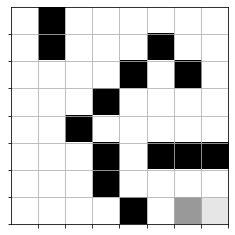

In [39]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

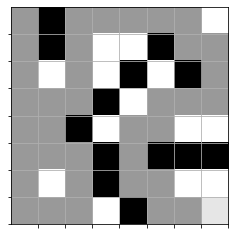

In [40]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.